In [20]:
import string
import numpy as np
import random
import torch

# read in data, remove punctuation and make all lower case
def read_corpus(filename):
    corpus = []
    translator = str.maketrans('', '', string.punctuation)
    with open(filename) as f:
        for s in f:
            clean_s = s.translate(translator).lower()
            clean_words = clean_s.split()
            corpus.append(clean_words)
    return corpus

#Make data dictionaries and indexing 
def make_dictionaries(corpus):
    # create one set of all unique words
    flat_corpus = [w for s in corpus for w in s]
    corpus_set = set(flat_corpus)
    w_to_i = {}
    i_to_w = {}
    w_freq = []
    num_words = len(corpus_set)
    for i, w in enumerate(corpus_set):
        w_to_i[w] = i
        i_to_w[i] = w
        freq = flat_corpus.count(w)   
        w_freq.append([i, freq])
    return w_to_i, i_to_w, np.array(w_freq), num_words

def make_word_windows(corpus, window_size):
    windows = []
    
    for sentence in corpus:
        for i, word in enumerate(sentence):
            curr_window = np.zeros(shape=[5])
            
            #Check if index allows large enough window sampling
            if (i - WINDOW_SIZE > 0) and (i+ WINDOW_SIZE < len(sentence)):
                word_index = w_to_i[word]
                curr_window[0] = word_index
                n=1
                for j in range(i-WINDOW_SIZE, i+WINDOW_SIZE):
                    context_index=w_to_i[sentence[j]]
                    curr_window[n:] = context_index
                    n+=1
                windows.append(torch.LongTensor(curr_window))
    return windows

In [25]:
WINDOW_SIZE = 2
EMBEDDING_DIM = 128
BATCH_SIZE = 64
NUM_EPOCHS = 30

In [26]:
#SOME DECISIONS TO MAKE HERE BEFORE RUNNING WITH LARGE CORPUS: 
### 1st: Word window
### 2nd: What to do when sentence is smaller than window size? Disregard? Fill with 0s? 
### If the above, fix vocab index for -UNK-
### For now only keeping windows if sentences are large enough


corpus = read_corpus('wa/test.en')
w_to_i, i_to_w, w_freq, num_words = make_dictionaries(corpus)
data = make_word_windows(corpus, WINDOW_SIZE)

In [27]:
import torch.nn as nn
from torch import distributions

class bayesian_skipgram(nn.Module):
    def __init__(self, num_words, emb_dim):
        super(bayesian_skipgram, self).__init__()

        self.num_words = num_words
        self.emb_dim = emb_dim

        self.R = nn.Embedding(num_words, emb_dim)
        self.mu_prior = nn.Embedding(num_words, emb_dim)
        self.sigma_prior  = nn.Embedding(num_words, emb_dim)
        
        self.M = nn.Linear(2*emb_dim, 2*emb_dim)
        self.affine_lambda_mu = nn.Linear(2*emb_dim, emb_dim)
        self.affine_lambda_sigma = nn.Linear(2*emb_dim, emb_dim)
        self.affine_theta = nn.Linear(emb_dim, num_words)
        

    def forward(self, word_idx, context_idx):
        
        batch_size = word_idx.shape[0]
        n_context = len(context_idx[0])
        
        # ********** Encoder ************
        
        R_w = self.R(word_idx) 
        R_w = R_w.view(batch_size, 1, self.emb_dim) 
        R_w = R_w.repeat(1, n_context, 1) 
        
        R_cj = self.R(context_idx)
        
        
        RcRw = torch.cat((R_w, R_cj), dim=2)
    
        h = nn.ReLU()(self.M(RcRw)) 
        h = torch.sum(h, dim=1)   

        mu = self.affine_lambda_mu(h)
        sigma = nn.functional.softplus(self.affine_lambda_sigma(h))

        # reparametrization trick
        eps = distributions.MultivariateNormal(torch.zeros(self.emb_dim), torch.eye(self.emb_dim)).sample()
        z = mu + sigma * eps    
               
            
        # ********* Decoder ***********
    
        affine_categ = self.affine_theta(z)
        f_i = nn.functional.softmax(affine_categ, dim=1)    
                            
        mu_prior = self.mu_prior(word_idx)
        sigma_prior = nn.functional.softplus(self.sigma_prior(word_idx))
            
        # ********** Loss ************
        
        likelihood_terms = torch.zeros(batch_size)
        KL_div_terms = torch.zeros(batch_size)
        
        for i, contexts in enumerate(context_idx):  
            likelihood = 0
            for idx in contexts:
                likelihood += torch.log(f_i[i, idx] +1e-8)
            likelihood_terms[i] = likelihood
            
            KL =  self.KL_div(mu_prior[i], sigma_prior[i],  mu[i],  sigma[i] )
            KL_div_terms[i] = KL
            
          
        total_loss = torch.mean(KL_div_terms) - torch.mean(likelihood_terms)
             
        return total_loss
    
    def KL_div(self,  mu_p, sigma_p, mu, sigma):
        div = torch.log(sigma_p + 1e-8) - torch.log(sigma+1e-8) + (sigma**2 + (mu - mu_p)**2) / (2*sigma_p**2) - 0.5
        return div.sum()

at batch  0
0.05086541175842285
tensor(1571.4757)
at batch  10
0.4946765899658203
tensor(813.2048)
at batch  20
0.5046517848968506
tensor(565.2198)
at batch  30
0.4866976737976074
tensor(752.6623)
at batch  40
0.4857015609741211
tensor(754.9451)
at batch  50
0.4757273197174072
tensor(540.2704)
at batch  60
0.4876983165740967
tensor(428.0025)
at batch  0
0.21642136573791504
tensor(758.2332)
at batch  10
0.6113681793212891
tensor(335.9749)
at batch  20
0.4986698627471924
tensor(322.9376)
at batch  30
0.4797170162200928
tensor(599.7666)
at batch  40
0.4687464237213135
tensor(328.2284)
at batch  50
0.5176165103912354
tensor(404.6554)
at batch  60
0.6363000869750977
tensor(478.3223)
at batch  0
0.26927900314331055
tensor(334.6642)
at batch  10
0.4797196388244629
tensor(675.4565)
at batch  20
0.48470401763916016
tensor(261.9224)
at batch  30
0.5634973049163818
tensor(24793.6055)
at batch  40
0.4976680278778076
tensor(230.3930)
at batch  50
0.4777224063873291
tensor(367.0016)
at batch  60
0.5

at batch  20
0.5046532154083252
tensor(33.9315)
at batch  30
0.48370862007141113
tensor(49.5700)
at batch  40
0.5485367774963379
tensor(41.3604)
at batch  50
0.5126328468322754
tensor(39.2457)
at batch  60
0.49268364906311035
tensor(40.1163)
at batch  0
0.2702760696411133
tensor(29.7706)
at batch  10
0.5046508312225342
tensor(33.6876)
at batch  20
0.5016610622406006
tensor(40.9644)
at batch  30
0.5006616115570068
tensor(33.9860)
at batch  40
0.5485343933105469
tensor(34.4313)
at batch  50
0.5415422916412354
tensor(32.4552)
at batch  60
0.47872018814086914
tensor(44.7647)
at batch  0
0.21841740608215332
tensor(35.5252)
at batch  10
0.5704758167266846
tensor(32.5602)
at batch  20
0.5086398124694824
tensor(29.9109)
at batch  30
0.4886937141418457
tensor(37.0481)
at batch  40
0.6023895740509033
tensor(33.5121)
at batch  50
0.5595049858093262
tensor(34.2009)
at batch  60
0.4976685047149658
tensor(36.6152)
at batch  0
0.22440314292907715
tensor(29.9508)
at batch  10
0.49068140983581543
tenso

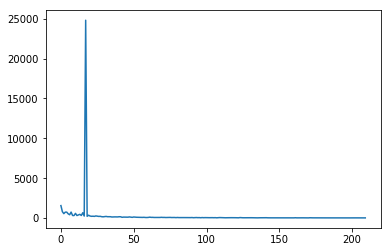

In [28]:
# TRAIN NETWORK
%matplotlib inline
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

start_time = time.time()

use_cuda = False#torch.cuda.is_available()

BSG_model = bayesian_skipgram(num_words, EMBEDDING_DIM)

if use_cuda:
    BSG_model.cuda()
optimizer = torch.optim.Adam(BSG_model.parameters(), lr=0.005)
BSG_model.train()
loss_progress = []
iter_time = time.time()

dataloader = DataLoader(data, batch_size=64, shuffle=True)

for epoch in range(NUM_EPOCHS):
    for i, batch in enumerate(dataloader):
        main_word = batch[:,0]
        context_word = batch[:,1:]

        #print("Main word:,", main_word.shape, context_word.shape)


        optimizer.zero_grad()

        if use_cuda:
            loss = BSG_model.forward(main_word.cuda(), context_word.cuda(), use_cuda=True)
        else:
            loss = BSG_model.forward(main_word, context_word)

        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print("epoch, batch ", epoch, i)
            loss_progress.append(loss.item())  
            print(time.time()-iter_time)
            print(loss)
            iter_time = time.time()
print("total time taken:", time.time()-start_time)
plt.plot(loss_progress)
plt.savefig('plot.png')
plt.show()

In [29]:
torch.save(BSG_model, 'bayesian_skipgram.pt')

C:\Users\Sindi\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type bayesian_skipgram. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [51]:
# read in all needed data

def get_test_data(filename):
    test_data = []
    with open(filename) as f:
        for line in f:
            line = line.split('\t')
            test_word = line[0]
            sentence_id = line[1]
            test_data.append([test_word, sentence_id])
    return(test_data)

def get_candidates(filename):
    with open(filename) as f:
        candidate_dict = {}
        for line in f:
            line = line.split('::')
            word = line[0]
            candidates = line[1].split(';')
            candidate_dict[word] = candidates
        return candidate_dict

In [52]:
import pickle
import torch

test_data = get_test_data('lst/lst_test.preprocessed')

candidates = get_candidates('lst/lst.gold.candidates')

with open('w2i_skipgram.pkl', 'rb') as f:
    w2i = pickle.load(f)

with open('i2w_skipgram.pkl', 'rb') as f:
    i2w = pickle.load(f)
    

In [53]:
use_cuda = torch.cuda.is_available()

if use_cuda: # load model with gpu (as it was trained)
    bayesian_skipgram_model = torch.load('bayesian_skipgram.pt')
else: # convert to cpu:
    bayesian_skipgram_model = torch.load('bayesian_skipgram.pt',  map_location='cpu')

In [54]:
# preprocessing - take out any words/candidates aren't present in original corpus (w2i check)  
orig_test_data = test_data[:]
for [word, sentence_id] in test_data[:]:
    word_nopos = word[:-2]
    if word_nopos not in w2i:
        test_data.remove([word, sentence_id])
    for candidate in candidates[word][:]:
        if candidate not in w2i:
            candidates[word].remove(candidate)

In [55]:
# convert words to indexes

word_is = [w2i[word[:-2]] for word, _ in test_data]
word_is = torch.LongTensor(word_is)

can_is = {}
for [word, _] in test_data[:]:
    can_i = [w2i[can] for can in candidates[word]]
    word_i = w2i[word[:-2]]
    can_is[word_i] = torch.LongTensor(can_i)

In [56]:
def get_ranking(word, candidates):

    cos = torch.nn.CosineSimilarity(dim=0)
    
    if use_cuda:
        word = word.cuda()

    word_embedding = bayesian_skipgram_model.R(word)
    can_sims = []
    for can in candidates:
        if use_cuda:
            can = can.cuda()
        can_embedding = bayesian_skipgram_model.R(can)
        sim = cos(word_embedding, can_embedding)
        can_sims.append([can, sim])
            
    can_sims = sorted(can_sims, key = lambda x: x[1])
    return(can_sims)

In [57]:
results = {}
for i, [word, sentence_id] in enumerate(test_data):
    word_i = word_is[i]
    cans = can_is[word_i.item()]
    rank = get_ranking(word_i, cans)
    words_scores = []
    for [candidate, score] in rank:
        can_word = i2w[candidate.item()]
        score = score.item()
        words_scores.append([can_word, score])
    results[word] = words_scores

In [58]:
with open('bayesian_skipgram_predictions', 'w') as f:
    for [word, sentence_id] in orig_test_data: # lst_gap needs all words, also once we do not have data for
        f.write('#RANKED\t')
        f.write(word + ' ')
        f.write(sentence_id)
        if word in results:
            for [candidate, score] in results[word]:
                f.write('\t' + candidate + ' ' + str(score))
        f.write('\n')

In [59]:
%run lst/lst_gap.py lst/lst_test.gold skipgram_predictions skipgram_out no-mwe


MEAN_GAP	0.06867063144654033

